In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Sat Nov  7 02:01:04 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    24W / 300W |      0MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Setup

In [2]:
from pathlib import Path
from zipfile import ZipFile
from matplotlib import pyplot as plt
import IPython.display as display
import random
import tensorflow as tf

#Data processing

## OAI Acelerated Osteoarthritis knee data set

OAI Acelerated Osteoarthritis knee data set (18K images) - This is part of the Osteoarthritis Initiative and
comes with only labelled laterality (left/right knee labelling) in the filename. The preprocessed version of
this data set can be found on the course Blackboard site (under Course Help/Resources).

In [3]:
path = '/content/drive/My Drive/colab/P4/AKOA_Analysis.zip'
raw_file = ZipFile(path)
raw_list = raw_file.namelist()
right_list = filter(lambda x: 'right' in x.lower() or 'r_i_g_h_t' in x.lower() ,raw_list)
left_list = filter(lambda x: 'left' in x.lower() or 'l_e_f_t' in x.lower() ,raw_list)

for vowel in right_list:
  raw_file.extract(vowel, 'data/right')
for vowel in left_list:
  raw_file.extract(vowel, 'data/left')
  

In [4]:

def check_photo(data_root):
  data_root = Path(data_root)
  all_image_paths = list(data_root.glob('*/*'))
  all_image_paths = [str(path) for path in all_image_paths]
  random.shuffle(all_image_paths)

  image_count = len(all_image_paths)
  print(image_count)
print('Total right photo has:')
check_photo('data/right')
print('Total left photo has:',)
check_photo('data/left')


Total right photo has:
10920
Total left photo has:
7760


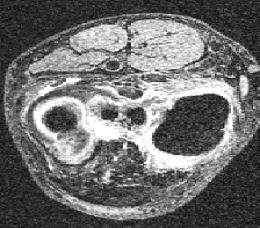

In [5]:
image_path = '/content/data/left/AKOA_Analysis/OAI9036287_BaseLine_3_de3d1_SAG_3D_DESS_WE_Left.nii.gz_0.png'
display.display(display.Image(image_path))

## Create a dataset


Define some parameters for the loader:

In [6]:
batch_size = 32
img_height = 224
img_width = 224

In [7]:
AUTOTUNE = tf.data.experimental.AUTOTUNE


class Img_dir:
    def __init__(self, path_list):
        self.path_dir = tf.data.Dataset.from_tensor_slices(path_list)

    def switch_dir(self):
        batch_size = round(len(self.path_dir) / 3)
        path_dir = self.path_dir.shuffle(len(self.path_dir))
        return path_dir.batch(batch_size)


class TotalDataset:
    def __init__(self, left_dir, right_dir):
        self.left_path_dir = [ds for ds in Img_dir(left_dir).switch_dir()]
        self.right_path_dir = [ds for ds in Img_dir(right_dir).switch_dir()]

    def get_path_label(self, index):
        left_xs = self.left_path_dir[index]
        left_ys = tf.zeros(len(left_xs), dtype=tf.int64)

        right_xs = self.right_path_dir[index]
        right_ys = tf.ones(len(right_xs), dtype=tf.int64)

        xs = tf.concat((left_xs, right_xs), axis=0)
        ys = tf.concat((left_ys, right_ys), axis=0)

        ys = tf.one_hot(ys, depth=2)

        img_paths = tf.data.Dataset.from_tensor_slices(xs)

        image_dir = img_paths.map(load_and_preprocess_image)
        label_dir = tf.data.Dataset.from_tensor_slices(ys)
        image_label_dir = tf.data.Dataset.zip((image_dir, label_dir))
        return image_label_dir

    def shuffle_buffer(self, image_label_dir, batch_size):
        # 设置一个和数据集大小一致的 shuffle buffer size（随机缓冲区大小）以保证数据
        # 被充分打乱。
        n = len(image_label_dir)
        ds = image_label_dir.shuffle(buffer_size=n)
        # ds = ds.repeat()
        ds = ds.batch(batch_size)
        # 当模型在训练的时候，`prefetch` 使数据集在后台取得 batch。
        ds = ds.prefetch(buffer_size=AUTOTUNE)
        return ds

    def get_train(self, batch_size):
        train_set = self.get_path_label(0)
        return self.shuffle_buffer(train_set, batch_size)

    def get_val(self, batch_size):
        val_set = self.get_path_label(1)
        return self.shuffle_buffer(val_set, batch_size)

    def get_test(self, batch_size):
        test_set = self.get_path_label(2)
        return self.shuffle_buffer(test_set, batch_size)


def preprocess_image(image, img_width=224, img_height=224):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [img_width, img_height])
    image /= 255.0  # normalize to [0,1] range
    return image


def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    return preprocess_image(image)

def get_dir(keyword):
    dir = [path.as_posix()
                for path in Path(data_root).rglob('**/'+keyword+'/**/*png')]

def get_dataset(data_root = 'data', batch_size = 32):
    left_dir = [path.as_posix()
                for path in Path(data_root).rglob('**/left/**/*png')]
    right_dir = [path.as_posix()
                 for path in Path(data_root).rglob('**/right/**/*png')]
    data_set = TotalDataset(left_dir, right_dir)

    trainset = data_set.get_train(batch_size)
    valset = data_set.get_val(batch_size)
    testset = data_set.get_test(batch_size)
    return trainset, valset, testset


In [8]:
trainset, valset, testset = get_dataset(data_root = 'data/')

In [15]:
model = tf.keras.models.Sequential()

# 1 VGG Blocks
model.add(tf.keras.layers.Conv2D(filters=64,kernel_size=3, activation='relu', padding='same', input_shape=(224, 224, 3)))
model.add(tf.keras.layers.Conv2D(filters=64,kernel_size=2,activation='relu'))
# model.add(tf.keras.layers.MaxPooling2D((2, 2), strides=2, padding='same'))
model.add(tf.keras.layers.Dropout(0.2))

# 2 VGG Blocks
model.add(tf.keras.layers.Conv2D(filters=64,kernel_size=3, activation='relu', padding='same', input_shape=(224, 224, 3)))
model.add(tf.keras.layers.Conv2D(filters=64,kernel_size=2,activation='relu'))
# model.add(tf.keras.layers.MaxPooling2D((2, 2), strides=2, padding='same'))
model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dropout(0.7))
model.add(tf.keras.layers.Dense(2, activation='softmax'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 223, 223, 64)      16448     
_________________________________________________________________
dropout_2 (Dropout)          (None, 223, 223, 64)      0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 3182656)           0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 3182656)           0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 6365314   
Total params: 6,383,554
Trainable params: 6,383,554
Non-trainable params: 0
____________________________________________

In [26]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    trainset,
    epochs=15,
    validation_data=valset,
    # validation_steps=10
)

Epoch 1/15
195/195 [==============================] - 47s 239ms/step - loss: 0.1372 - accuracy: 0.9865 - val_loss: 5.4412e-04 - val_accuracy: 1.0000
Epoch 2/15
195/195 [==============================] - 46s 238ms/step - loss: 4.9412e-05 - accuracy: 1.0000 - val_loss: 1.5971e-04 - val_accuracy: 1.0000
Epoch 3/15
195/195 [==============================] - 46s 236ms/step - loss: 1.5178e-05 - accuracy: 1.0000 - val_loss: 6.8459e-05 - val_accuracy: 1.0000
Epoch 4/15
195/195 [==============================] - 47s 241ms/step - loss: 5.5823e-06 - accuracy: 1.0000 - val_loss: 3.2114e-05 - val_accuracy: 1.0000
Epoch 5/15
195/195 [==============================] - 47s 239ms/step - loss: 4.1083e-06 - accuracy: 1.0000 - val_loss: 1.3409e-04 - val_accuracy: 1.0000
Epoch 6/15
195/195 [==============================] - 47s 240ms/step - loss: 4.3576e-06 - accuracy: 1.0000 - val_loss: 2.9248e-05 - val_accuracy: 1.0000
Epoch 7/15
195/195 [==============================] - 46s 238ms/step - loss: 1.3120e-0

## Evaluation and prediction

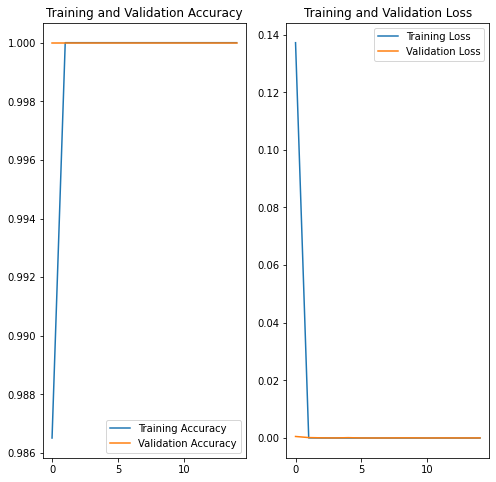

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(15)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

The Test accuracy is：

In [31]:


loss, accuracy = model.evaluate(testset)


195/195 [==============================] - 3s 14ms/step - loss: 2.4936e-05 - accuracy: 1.0000
